<a href="https://colab.research.google.com/github/avisekh007/signature_verification_ml/blob/main/ee_62_sign_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
import glob
from zipfile import ZipFile
from google.colab import files

In [65]:
# Import your kaggle API token from local directory
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"avisekh007","key":"b45e4d5c86fdbab7fd21cecdd6b4cc67"}'}

In [66]:
# Copy the API token and change permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [67]:
# Download datasets from kaggle
#!kaggle datasets download -d divyanshrai/handwritten-signatures
!kaggle datasets download -d robinreni/signature-verification-dataset

 97% 585M/601M [00:04<00:00, 77.0MB/s]
100% 601M/601M [00:04<00:00, 127MB/s] 


In [68]:
# Extract dataset archives
#ZipFile("handwritten-signatures.zip", 'r').extractall("handwritten-signatures")
ZipFile("signature-verification-dataset.zip", 'r').extractall("signature-verification-dataset")

In [69]:
# Remove unwanted stuffs
!rm -rf handwritten-signatures.zip signature-verification-dataset.zip kaggle.json
#!rm -rf handwritten-signatures signature-verification-dataset

In [70]:
# Set training and testing directory
train_loc = "signature-verification-dataset/sign_data/train/"
test_loc = "signature-verification-dataset/sign_data/test/"

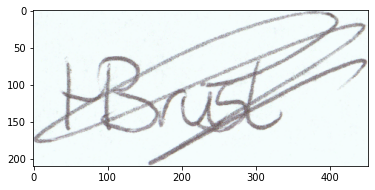

In [71]:
# Show an original signature
sign_orig = plt.imread('signature-verification-dataset/sign_data/train/009/009_03.PNG')
plt.imshow(sign_orig)

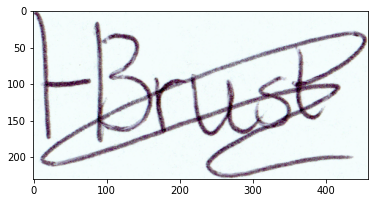

In [72]:
# Show a forged signature
sign_forg = plt.imread('signature-verification-dataset/sign_data/sign_data/train/009_forg/0201009_04.png')
plt.imshow(sign_forg)

In [180]:
size = 200

In [181]:
import os

# Import Training Data
# Label: Original = 0, Forged = 1

train_data = []
train_labels = []

for per in os.listdir(train_loc):
    for data in glob.glob(train_loc + per + '/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size, size))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

In [182]:
# Import Testing Data
# Label: Original = 0, Forged = 1

test_data = []
test_labels = []

for per in os.listdir(test_loc):
    for data in glob.glob(test_loc + per + '/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (size, size))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(1)
        else:
            test_labels.append(0)

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [183]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels, dtype="float32")

In [184]:
train_data.shape

(1649, 1, 200, 200, 3)

In [185]:
# Resize train data array based upon training data available
train_data = train_data.reshape(-1, size, size, 3)
train_data.shape

(1649, 200, 200, 3)

In [186]:
# Resize test data array based upon training data available
test_data = test_data.reshape(-1, size, size, 3)
test_data.shape

(500, 200, 200, 3)

In [187]:
train_labels.shape

(1649, 2)

In [188]:
from sklearn.utils import shuffle

# Organize and shuffle the data
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [189]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [190]:
# Configuring the CNN layer
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

# Base VGG19 layer
base_model = applications.VGG19(weights='imagenet', include_top=False, input_shape=(size, size, 3))

# Custom layers
add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(64, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0  

In [191]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0.01,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]


epochs_count = 20
batch_size = 64
progress = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs_count, callbacks=early_stop, validation_split=.3)

Epoch 1/20
19/19 [==============================] - 19s 948ms/step - loss: 0.7400 - accuracy: 0.5253 - val_loss: 0.5846 - val_accuracy: 0.7556
Epoch 2/20
19/19 [==============================] - 18s 971ms/step - loss: 0.4840 - accuracy: 0.7643 - val_loss: 0.2199 - val_accuracy: 0.9192
Epoch 3/20
19/19 [==============================] - 18s 938ms/step - loss: 0.2196 - accuracy: 0.9283 - val_loss: 0.1094 - val_accuracy: 0.9475
Epoch 4/20
19/19 [==============================] - 17s 910ms/step - loss: 0.0946 - accuracy: 0.9678 - val_loss: 0.1228 - val_accuracy: 0.9535
Epoch 5/20
19/19 [==============================] - 17s 908ms/step - loss: 0.0324 - accuracy: 0.9888 - val_loss: 0.1283 - val_accuracy: 0.9495
Epoch 6/20
19/19 [==============================] - 17s 925ms/step - loss: 0.1341 - accuracy: 0.9498 - val_loss: 0.0874 - val_accuracy: 0.9697
Epoch 7/20
19/19 [==============================] - 18s 935ms/step - loss: 0.0508 - accuracy: 0.9869 - val_loss: 0.0561 - val_accuracy: 0.9818

<Figure size 432x288 with 0 Axes>

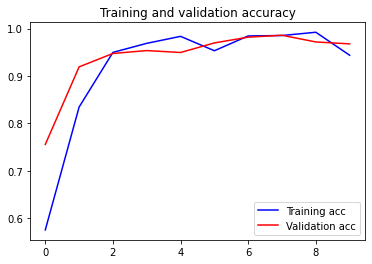

<Figure size 432x288 with 0 Axes>

In [192]:
# Plot training and validation accuracy
acc = progress.history['accuracy']
val_acc = progress.history['val_accuracy']
loss = progress.history['loss']
val_loss = progress.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

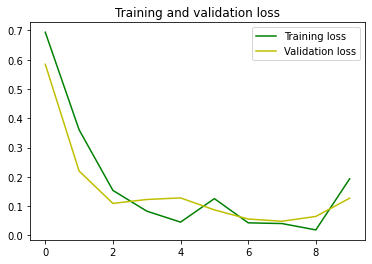

In [193]:
# Plot training and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [194]:
pred = model.predict(test_data)

In [195]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)

0.99

In [196]:
pred = model.predict(test_data)
predict = np.argmax(pred,axis=1)

In [197]:
from sklearn.metrics import accuracy_score
accuracy_score(predict , test_labels)

0.99

In [198]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
f1_score(predict, test_labels)

0.9898167006109979

In [199]:
recall_score(predict, test_labels)

1.0

In [200]:
precision_score(predict,test_labels)

0.9798387096774194

In [201]:
confusion_matrix(predict,test_labels)

array([[252,   5],
       [  0, 243]])